## Define Tetris Game

In [1]:
import numpy as np
import random

class Tetris:
    
    UNDEFINED = -1
    
    TILES = [
        [
            [[0, 2]],  # Tile 0, orientation 0.
            [[0, 1], [0, 1]],  # Tile 0, orientation 1.
        ],
        [
            [[0, 1], [1, 2]],  # Tile 1, orientation 0.
            [[1, 2], [0, 1]],  # Tile 1, orientation 0.
        ],
        [
            [[0, 2], [1, 2]],  # Tile 2, orientation 0.
            [[0, 2], [0, 1]],  # Tile 2, orientation 1.
            [[0, 1], [0, 2]],  # Tile 2, orientation 2.
            [[1, 2], [0, 2]],  # Tile 2, orientation 3.
        ],
        [
            [[0, 2], [0, 2]],  # Tile 4, orientation 0.
        ],
    ]

    def __init__(self, rows, cols, max_tiles, random_seed):
        self.rows, self.cols = rows, cols
        self.max_tiles = max_tiles
        self.random_seed = random_seed
        
        self.restart()
        
    def restart(self):
        self.gameover = False
        self.tile_count = 0
        self.reward = 0
        self.board = np.full((self.rows, self.cols), Tetris.UNDEFINED)
        self.current_tile = Tetris.UNDEFINED
        self.tile_x = Tetris.UNDEFINED
        self.tile_y = Tetris.UNDEFINED
        self.tile_orientation = Tetris.UNDEFINED
        
        # Create predefined tile sequence, used if stochastic_prob=0
        rand_state = random.getstate()
        random.seed(self.random_seed)
        self.tile_sequence = [random.randint(0, len(Tetris.TILES) - 1) 
                              for x in range(self.max_tiles)]
        random.setstate(rand_state)
        
        self.next_tile()
        
    def next_tile(self):
        if self.tile_count < self.max_tiles:
            if self.random_seed is not None:
                self.current_tile = self.tile_sequence[self.tile_count]
            else:
                self.current_tile = random.randint(0, len(Tetris.TILES) - 1)
            
            self.tile_x = self.cols // 2
            self.tile_y = self.rows
            self.tile_orientation = 0
            self.tile_count += 1
        else:
            self.gameover = True
    
    def move_left(self):
        if self.tile_x - 1 >= 0:
            self.tile_x -= 1
            return True
        else:
            return False
    
    def move_right(self):
        tile_width = len(Tetris.TILES[self.current_tile][self.tile_orientation])
        if self.tile_x + 1 <= self.cols - tile_width:
            self.tile_x += 1
            return True
        else:
            return False
    
    def rotate(self):
        new_orientation = ((self.tile_orientation + 1) 
                           % len(Tetris.TILES[self.current_tile]))
        tile_width = len(Tetris.TILES[self.current_tile][new_orientation])
        if self.tile_x <= self.cols - tile_width:
            self.tile_orientation = new_orientation
            return True
        else:
            return False
        
    def drop(self):
        tile = Tetris.TILES[self.current_tile][self.tile_orientation]
        
        # Find first location where the piece collides with occupied locations.
        self.tile_y = 0
        for x in range(len(tile)):
            # Find first occupied location in this column            
            cury = -1
            for y in range(self.rows -1, -1, -1):
                if self.board[y, self.tile_x + x] > 0:
                    # Calculate the y position for this column if no other columns are taken into account
                    cury = y + 1 - tile[x][0]
                    break
            # Use the largest y position for all columns of the tile
            if self.tile_y < cury:
                self.tile_y = cury

        if self.tile_y + np.max(tile) > self.rows:
            self.gameover = True
            dreward = -100
        else:
            # Change board entries at the newly placed tile to occupied.
            for x in range(len(tile)):
                self.board[self.tile_y + tile[x][0]:self.tile_y + tile[x][1], 
                           x + self.tile_x] = 1

            # Remove full lines.
            removed_lines = 0
            for y in range(self.rows - 1, -1, -1):
                if np.sum(self.board[y, :]) == self.cols:
                    removed_lines += 1
                    for y1 in range(y, self.rows - 1):
                        self.board[y1, :] = self.board[y1 + 1, :]
                    self.board[self.rows - 1, :] = Tetris.UNDEFINED
            
            dreward = 10 ** (removed_lines - 1) if removed_lines > 0 else 0
            
            # Choose the next tile.
            self.next_tile()
        
        self.reward += dreward
        
        return dreward

In [2]:
tetris = Tetris(rows=5, cols=4, max_tiles=50, random_seed=123456)

while not tetris.gameover:
    print(f"Tile {tetris.tile_count}/{tetris.max_tiles}")
    print(f"Reward: {tetris.reward}")
    print(f"Current tile {tetris.current_tile} with orientation {tetris.tile_orientation} at position {tetris.tile_x}")
    print(tetris.TILES[tetris.current_tile][tetris.tile_orientation])
    print(tetris.board)
    
    cmd = input("Please enter your command (L, R, O, D, X): ").upper()
    print(f"Your input: {cmd}")

    if cmd == "L":
        tetris.move_left()
    elif cmd == "R":
        tetris.move_right()
    elif cmd == "O":
        tetris.rotate()
    elif cmd == "D":
        tetris.drop()
    elif cmd == "X":
        break

Tile 1/50
Reward: 0
Current tile 2 with orientation 0 at position 2
[[0, 2], [1, 2]]
[[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]]
Your input: 
Tile 1/50
Reward: 0
Current tile 2 with orientation 0 at position 2
[[0, 2], [1, 2]]
[[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]]
Your input: L
Tile 1/50
Reward: 0
Current tile 2 with orientation 0 at position 1
[[0, 2], [1, 2]]
[[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]]
Your input: Ö
Tile 1/50
Reward: 0
Current tile 2 with orientation 0 at position 1
[[0, 2], [1, 2]]
[[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]]
Your input: Ö
Tile 1/50
Reward: 0
Current tile 2 with orientation 0 at position 1
[[0, 2], [1, 2]]
[[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]]
Your input: L
Tile 1/50
Reward: 0
Current tile 2 with orientation 0 at position 0
[[0, 2], [1, 2]]
[[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 

In [3]:
import pygame

tetris = Tetris(rows=5, cols=4, max_tiles=50, random_seed=123456)

# GUI parameters.
TILE_SIZE = 20

BLACK = (0, 0, 0)
GREY = (128, 128, 128)
WHITE = (255, 255, 255)
RED =  (255, 0, 0)

# Initialize the game engine.
pygame.init()
pygame.display.set_caption("TETRIS")
screen = pygame.display.set_mode((200 + tetris.cols * TILE_SIZE, 
                                  200 + tetris.rows * TILE_SIZE))
pygame.key.set_repeat(300, 100)  # Set keyboard delay and interval in ms.
font = pygame.font.SysFont("Calibri", 25, True)

# Loop until the window is closed.
running = True
while running:
    
    # Get user input.
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_ESCAPE:
                tetris.restart()
            if not tetris.gameover:
                if event.key == pygame.K_LEFT:
                    tetris.move_left()
                elif event.key == pygame.K_RIGHT:
                    tetris.move_right()
                elif event.key == pygame.K_UP:
                    tetris.rotate()
                elif event.key == pygame.K_DOWN:
                    tetris.drop()
    
    # Paint game board.
    if pygame.display.get_active():
        screen.fill(WHITE)

        for i in range(tetris.rows):
            for j in range(tetris.cols):
                pygame.draw.rect(screen, 
                    GREY, 
                    [
                        100 + TILE_SIZE * j, 
                        80 + TILE_SIZE * (tetris.rows - i), 
                        TILE_SIZE, 
                        TILE_SIZE,
                    ], 
                    1
                )
                if tetris.board[i][j] > 0:
                    pygame.draw.rect(
                        screen, 
                        BLACK,
                        [
                            101 + TILE_SIZE * j, 
                            81 + TILE_SIZE * (tetris.rows - i), 
                            TILE_SIZE - 2, 
                            TILE_SIZE - 2,
                        ],
                    )
        
        tile = tetris.TILES[tetris.current_tile][tetris.tile_orientation]
        for x in range(len(tile)):
            for y in range(tile[x][0], tile[x][1]):
                pygame.draw.rect(
                    screen,
                    RED,
                    [
                        101 + TILE_SIZE * (x + tetris.tile_x), 
                        81 + TILE_SIZE * (tetris.rows - (y + tetris.tile_y)), 
                        TILE_SIZE - 2,
                        TILE_SIZE - 2,
                    ]
                )
        
        screen.blit(font.render(f"Reward: {tetris.reward}", 
                                True, BLACK), [0, 0])
        screen.blit(font.render(f"Tile {tetris.tile_count}/{tetris.max_tiles}", 
                                True, BLACK), [0, 30])
        if tetris.gameover:
            screen.blit(font.render("G A M E   O V E R", True, RED), 
                        [40, 100 + tetris.rows * TILE_SIZE])
            screen.blit(font.render("Press ESC to try again", True, RED), 
                        [10, 100 + tetris.rows * TILE_SIZE + 30])

    pygame.display.flip()
            
pygame.quit()


pygame 2.5.2 (SDL 2.28.3, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Adaptation to Q-Learning

In [4]:
class QLTetris(Tetris):
    
    def __init__(self, rows, cols, max_tiles, random_seed):
        super().__init__(rows, cols, max_tiles, random_seed)
    
    def teleport(self, new_x, new_orientation):
        if 0 <= new_orientation < len(Tetris.TILES[self.current_tile]):  # Valid orientation.
            tile_width = len(Tetris.TILES[self.current_tile][new_orientation])
            if 0 <= new_x <= self.cols - tile_width:
                self.tile_x = new_x
                self.tile_orientation = new_orientation
                return True
        return False

In reinforcement learning, the discount factor γ (gamma) is a crucial parameter that determines how future rewards are taken into account in the agent's decision-making process. Typical values for gamma generally range between 0 and 1, and the choice of this value depends on the specific characteristics of the problem and the desired balance between immediate and future rewards. Here's an overview of how different values of gamma affect the learning process:

1. **γ close to 0**: 
   - When gamma is close to 0, the agent tends to be short-sighted and prioritizes immediate rewards over future rewards. This is because future rewards are heavily discounted, making them less significant in the agent's decision-making process.
   - Use this approach in environments where immediate rewards are more important or when the future is highly uncertain.

2. **γ close to 1**:
   - When gamma is close to 1, the agent considers future rewards almost as important as immediate rewards. This encourages the agent to plan for the long term and can lead to more strategic behavior.
   - Use this approach in environments where it's important to consider the long-term consequences of actions and where future rewards are relatively certain.

3. **Intermediate values (e.g., 0.8, 0.9)**:
   - Intermediate values of gamma strike a balance between valuing immediate and future rewards. These values are often used in practice as they allow the agent to consider both short-term and long-term outcomes.
   - This approach is suitable for many standard reinforcement learning problems.

It's important to note that the optimal value of gamma can vary depending on the specific problem and the environment's dynamics. In practice, finding the best value for gamma might require experimentation and tuning. Additionally, a gamma value of exactly 1 can be used in certain theoretical settings, particularly when dealing with undiscounted finite-horizon problems, but in practice, a value slightly less than 1 is often preferred to ensure convergence and stability.

### QLAgent 1

only actions - nothing happens if teleportation is to illegal place

In [5]:
class QLAgent:
    
    def __init__(self, tetris, games):
        """Initialize the agent."""
        
        self.tetris = tetris
        
        self.games = games
        self.game = 0
        
        self.position_num = self.tetris.rows
        self.orientation_num = np.max([len(tile) for tile in Tetris.TILES])
        self.action_num = self.position_num * self.orientation_num

    def next_turn(self):
        """Executes the next turn in the game."""
        
        if self.tetris.gameover:
            self.game += 1
            if self.game < self.games:
                self.tetris.restart()
            else:
                return False  # Finish.
        else:
            action = np.random.randint(self.action_num)
            
            # Extract rotation and movement from action parameter.
            new_x = action // self.position_num
            new_orientation = action % self.orientation_num

            # Execute action and drop tile.
            if self.tetris.teleport(new_x, new_orientation):  # Note that nothing happens if the teleportation is not valid.
                self.tetris.drop()
            
        return True  # Continue.

In [6]:
import pygame

tetris = QLTetris(rows=4, cols=4, max_tiles=50, random_seed=123456)
agent = QLAgent(tetris=tetris, games=1000)

# GUI parameters.
TILE_SIZE = 20

BLACK = (0, 0, 0)
GREY = (128, 128, 128)
WHITE = (255, 255, 255)
RED =  (255, 0, 0)

# Initialize the game engine.
pygame.init()
pygame.display.set_caption("TETRIS")
screen = pygame.display.set_mode((200 + tetris.cols * TILE_SIZE, 
                                  200 + tetris.rows * TILE_SIZE))
pygame.key.set_repeat(300, 100)  # Set keyboard delay and interval in ms.
font = pygame.font.SysFont("Calibri", 25, True)

# Loop until the window is closed.
running = True
while running:
        
    # Paint game board.
    if pygame.display.get_active():
        screen.fill(WHITE)

        for i in range(tetris.rows):
            for j in range(tetris.cols):
                pygame.draw.rect(screen, 
                    GREY, 
                    [
                        100 + TILE_SIZE * j, 
                        80 + TILE_SIZE * (tetris.rows - i), 
                        TILE_SIZE, 
                        TILE_SIZE,
                    ], 
                    1
                )
                if tetris.board[i][j] > 0:
                    pygame.draw.rect(
                        screen, 
                        BLACK,
                        [
                            101 + TILE_SIZE * j, 
                            81 + TILE_SIZE * (tetris.rows - i), 
                            TILE_SIZE - 2, 
                            TILE_SIZE - 2,
                        ],
                    )
        
        tile = tetris.TILES[tetris.current_tile][tetris.tile_orientation]
        for x in range(len(tile)):
            for y in range(tile[x][0], tile[x][1]):
                pygame.draw.rect(
                    screen,
                    RED,
                    [
                        101 + TILE_SIZE * (x + tetris.tile_x), 
                        81 + TILE_SIZE * (tetris.rows - (y + tetris.tile_y)), 
                        TILE_SIZE - 2,
                        TILE_SIZE - 2,
                    ]
                )
        
        screen.blit(font.render(f"Reward: {tetris.reward}", 
                                True, BLACK), [0, 0])
        screen.blit(font.render(f"Tile {tetris.tile_count}/{tetris.max_tiles}", 
                                True, BLACK), [0, 30])
        if tetris.gameover:
            screen.blit(font.render("G A M E   O V E R", True, RED), 
                        [40, 100 + tetris.rows * TILE_SIZE])
            screen.blit(font.render("Press ESC to try again", True, RED), 
                        [10, 100 + tetris.rows * TILE_SIZE + 30])

    pygame.display.flip()

    # Get user input.
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN:
            agent.next_turn()
            
pygame.quit()

Note that sometimes it doesn't drop because the action is not legal.

### QLAgent 2

Also states - the rest same as in 1

In [7]:
class QLAgent:
    
    def __init__(self, tetris, games):
        """Initialize the agent."""
        
        self.tetris = tetris

        self.games = games
        self.game = 0

        self.state_size = (
            self.tetris.cols * self.tetris.rows  # Cells in board.
            + 1 + np.floor(np.log2(len(Tetris.TILES) - 1)).astype(int)  # Tiles
        )
        self.state_num = 2 ** self.state_size
        
        self.position_num = self.tetris.rows
        self.orientation_num = np.max([len(tile) for tile in Tetris.TILES])
        self.action_num = self.position_num * self.orientation_num

        self.update_state()

    def update_state(self):
        """Update the state of the agent."""
        
        # Convert tile to binary list.
        tile = bin(self.tetris.current_tile)[2:]

        # Convert board to binary list.
        board = np.copy(self.tetris.board.reshape((-1,))).astype(int)
        board[board == Tetris.UNDEFINED] = 0
        
        self.state_binary = np.append(tile, board)
        self.state = int("".join(str(i) for i in self.state_binary), 2)

    def next_turn(self):
        """Executes the next turn in the game."""
        
        if self.tetris.gameover:
            self.game += 1
            if self.game < self.games:
                self.tetris.restart()
            else:
                return False  # Finish.
        else:
            old_state = self.state
            
            # Select action.
            action = np.random.randint(self.action_num)
            
            # Extract rotation and movement from action parameter.
            new_x = action // self.position_num
            new_orientation = action % self.orientation_num

            # Execute action and drop tile.
            if self.tetris.teleport(new_x, new_orientation):
                reward = self.tetris.drop()
                    
                # Update the state.
                self.update_state()
                new_state = self.state
                
        return True  # Continue.

In [8]:
import pygame

tetris = QLTetris(rows=4, cols=4, max_tiles=50, random_seed=123456)
agent = QLAgent(tetris=tetris, games=1000)

# GUI parameters.
TILE_SIZE = 20

BLACK = (0, 0, 0)
GREY = (128, 128, 128)
WHITE = (255, 255, 255)
RED =  (255, 0, 0)

# Initialize the game engine.
pygame.init()
pygame.display.set_caption("TETRIS")
screen = pygame.display.set_mode((200 + tetris.cols * TILE_SIZE, 
                                  200 + tetris.rows * TILE_SIZE))
pygame.key.set_repeat(300, 100)  # Set keyboard delay and interval in ms.
font = pygame.font.SysFont("Calibri", 25, True)

# Loop until the window is closed.
running = True
while running:
        
    # Paint game board.
    if pygame.display.get_active():
        screen.fill(WHITE)

        for i in range(tetris.rows):
            for j in range(tetris.cols):
                pygame.draw.rect(screen, 
                    GREY, 
                    [
                        100 + TILE_SIZE * j, 
                        80 + TILE_SIZE * (tetris.rows - i), 
                        TILE_SIZE, 
                        TILE_SIZE,
                    ], 
                    1
                )
                if tetris.board[i][j] > 0:
                    pygame.draw.rect(
                        screen, 
                        BLACK,
                        [
                            101 + TILE_SIZE * j, 
                            81 + TILE_SIZE * (tetris.rows - i), 
                            TILE_SIZE - 2, 
                            TILE_SIZE - 2,
                        ],
                    )
        
        tile = tetris.TILES[tetris.current_tile][tetris.tile_orientation]
        for x in range(len(tile)):
            for y in range(tile[x][0], tile[x][1]):
                pygame.draw.rect(
                    screen,
                    RED,
                    [
                        101 + TILE_SIZE * (x + tetris.tile_x), 
                        81 + TILE_SIZE * (tetris.rows - (y + tetris.tile_y)), 
                        TILE_SIZE - 2,
                        TILE_SIZE - 2,
                    ]
                )
        
        screen.blit(font.render(f"Reward: {tetris.reward}", 
                                True, BLACK), [0, 0])
        screen.blit(font.render(f"Tile {tetris.tile_count}/{tetris.max_tiles}", 
                                True, BLACK), [0, 30])
        if tetris.gameover:
            screen.blit(font.render("G A M E   O V E R", True, RED), 
                        [40, 100 + tetris.rows * TILE_SIZE])
            screen.blit(font.render("Press ESC to try again", True, RED), 
                        [10, 100 + tetris.rows * TILE_SIZE + 30])

    pygame.display.flip()

    # Get user input.
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN:
            agent.next_turn()
            
pygame.quit()

### QLAgent 3

Choose strategy from Q-matrix - note that it teleports all tiles to position 0 and orientation 0

In [9]:
class QLAgent:
    
    def __init__(self, tetris, games, epsilon):
        """Initialize the agent."""
        
        self.tetris = tetris
        
        self.games = games
        self.game = 0

        self.epsilon = epsilon  # Probability to choose a random action in the epsilon-greedy policy.

        self.state_size = (
            self.tetris.cols * self.tetris.rows  # Cells in board.
            + 1 + np.floor(np.log2(len(Tetris.TILES) - 1)).astype(int)  # Tiles
        )
        self.state_num = 2 ** self.state_size
        
        self.position_num = self.tetris.rows
        self.orientation_num = np.max([len(tile) for tile in Tetris.TILES])
        self.action_num = self.position_num * self.orientation_num

        self.Q_table = np.zeros((self.state_num, self.action_num))
        
        self.update_state()

    def update_state(self):
        """Update the state of the agent."""
        
        # Convert tile to binary list.
        tile = bin(self.tetris.current_tile)[2:]

        # Convert board to binary list.
        board = np.copy(self.tetris.board.reshape((-1,))).astype(int)
        board[board == Tetris.UNDEFINED] = 0
        
        self.state_binary = np.append(tile, board)
        self.state = int("".join(str(i) for i in self.state_binary), 2)

    def next_turn(self):
        """Executes the next turn in the game."""
        
        if self.tetris.gameover:
            self.game += 1
            if self.game < self.games:
                self.tetris.restart()
            else:
                return False  # Finish.
        else:
            old_state = self.state
            
            # Select action.
            if np.random.rand() < self.epsilon:
                action = np.random.randint(self.action_num)
            else:
                action = np.argmax(self.Q_table[old_state, :])
            
            # Extract rotation and movement from action parameter.
            new_x = action // self.position_num
            new_orientation = action % self.orientation_num

            # Execute action and drop tile.
            if self.tetris.teleport(new_x, new_orientation):
                self.tetris.drop()
                    
                # Update the state.
                self.update_state()
                new_state = self.state
            
        return True  # Continue.

In [10]:
import pygame

tetris = QLTetris(rows=4, cols=4, max_tiles=50, random_seed=123456)
agent = QLAgent(tetris=tetris, games=1000, epsilon=0)

# GUI parameters.
TILE_SIZE = 20

BLACK = (0, 0, 0)
GREY = (128, 128, 128)
WHITE = (255, 255, 255)
RED =  (255, 0, 0)

# Initialize the game engine.
pygame.init()
pygame.display.set_caption("TETRIS")
screen = pygame.display.set_mode((200 + tetris.cols * TILE_SIZE, 
                                  200 + tetris.rows * TILE_SIZE))
pygame.key.set_repeat(300, 100)  # Set keyboard delay and interval in ms.
font = pygame.font.SysFont("Calibri", 25, True)

# Loop until the window is closed.
running = True
while running:
        
    # Paint game board.
    if pygame.display.get_active():
        screen.fill(WHITE)

        for i in range(tetris.rows):
            for j in range(tetris.cols):
                pygame.draw.rect(screen, 
                    GREY, 
                    [
                        100 + TILE_SIZE * j, 
                        80 + TILE_SIZE * (tetris.rows - i), 
                        TILE_SIZE, 
                        TILE_SIZE,
                    ], 
                    1
                )
                if tetris.board[i][j] > 0:
                    pygame.draw.rect(
                        screen, 
                        BLACK,
                        [
                            101 + TILE_SIZE * j, 
                            81 + TILE_SIZE * (tetris.rows - i), 
                            TILE_SIZE - 2, 
                            TILE_SIZE - 2,
                        ],
                    )
        
        tile = tetris.TILES[tetris.current_tile][tetris.tile_orientation]
        for x in range(len(tile)):
            for y in range(tile[x][0], tile[x][1]):
                pygame.draw.rect(
                    screen,
                    RED,
                    [
                        101 + TILE_SIZE * (x + tetris.tile_x), 
                        81 + TILE_SIZE * (tetris.rows - (y + tetris.tile_y)), 
                        TILE_SIZE - 2,
                        TILE_SIZE - 2,
                    ]
                )
        
        screen.blit(font.render(f"Reward: {tetris.reward}", 
                                True, BLACK), [0, 0])
        screen.blit(font.render(f"Tile {tetris.tile_count}/{tetris.max_tiles}", 
                                True, BLACK), [0, 30])
        if tetris.gameover:
            screen.blit(font.render("G A M E   O V E R", True, RED), 
                        [40, 100 + tetris.rows * TILE_SIZE])
            screen.blit(font.render("Press ESC to try again", True, RED), 
                        [10, 100 + tetris.rows * TILE_SIZE + 30])

    pygame.display.flip()

    # Get user input.
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN:
            agent.next_turn()
            
pygame.quit()

### QLAgent 4

Complete version, also training the Q-matrix

In [11]:
class QLAgent:
    
    def __init__(self, tetris, games, epsilon, alpha, gamma):
        """Initialize the agent."""
        
        self.tetris = tetris

        self.games = games
        self.game = 0

        self.epsilon = epsilon  # Probability to choose a random action in the epsilon-greedy policy.
        self.alpha = alpha  # Alpha is the learning rate.
        self.gamma = gamma  # Discount factor.
        
        self.rewards = np.zeros(games)

        self.state_size = (
            self.tetris.cols * self.tetris.rows  # Cells in board.
            + 1 + np.floor(np.log2(len(Tetris.TILES) - 1)).astype(int)  # Tiles
        )
        self.state_num = 2 ** self.state_size
        
        self.position_num = self.tetris.rows
        self.orientation_num = np.max([len(tile) for tile in Tetris.TILES])
        self.action_num = self.position_num * self.orientation_num

        self.Q_table = np.zeros((self.state_num, self.action_num))
        
        self.update_state()

    def update_state(self):
        """Update the state of the agent."""
        
        # Convert tile to binary list.
        tile = bin(self.tetris.current_tile)[2:]

        # Convert board to binary list.
        board = np.copy(self.tetris.board.reshape((-1,))).astype(int)
        board[board == Tetris.UNDEFINED] = 0
        
        self.state_binary = np.append(tile, board)
        self.state = int("".join(str(i) for i in self.state_binary), 2)

    def next_turn(self):
        """Executes the next turn in the game."""
        
        if self.tetris.gameover:
            self.rewards[self.game] = self.tetris.reward
            if self.game % 100 == 0:
                av_reward = np.mean(self.rewards[self.game - 100:self.game])
                print(f"game {self.game}/{self.games} reward {av_reward}")
            
            self.game += 1
            if self.game < self.games:
                self.tetris.restart()
            else:
                np.savetxt('Q_table.txt', self.Q_table)
                return False  # Finish.
        else:
            old_state = self.state
            
            # Select action.
            if np.random.rand() < self.epsilon:
                action = np.random.randint(self.action_num)
            else:
                action = np.argmax(self.Q_table[old_state, :])
            
            # Extract rotation and movement from action parameter.
            new_x = action // self.position_num
            new_orientation = action % self.orientation_num

            # Execute action and drop tile.
            if self.tetris.teleport(new_x, new_orientation):
                reward = self.tetris.drop()
                    
                # Update the state.
                self.update_state()
                new_state = self.state
                
                # Update the Q-table using the old state and the reward.
                dQ = self.alpha * (
                    reward
                    + self.gamma * np.max(self.Q_table[new_state, :])
                    - self.Q_table[old_state, action]
                )
                            
                # Update the Q-table.
                self.Q_table[old_state, action] += dQ
            else:  # Penalty for illegal move.
                self.Q_table[old_state, action] += -50
            
        return True  # Continue.

In [12]:
import pygame

tetris = QLTetris(rows=4, cols=4, max_tiles=50, random_seed=123456)
agent = QLAgent(tetris=tetris, games=1000, epsilon=0, alpha=0.2, gamma=1)

# GUI parameters.
TILE_SIZE = 20

BLACK = (0, 0, 0)
GREY = (128, 128, 128)
WHITE = (255, 255, 255)
RED =  (255, 0, 0)

# Initialize the game engine.
pygame.init()
pygame.display.set_caption("TETRIS")
screen = pygame.display.set_mode((200 + tetris.cols * TILE_SIZE, 
                                  200 + tetris.rows * TILE_SIZE))
pygame.key.set_repeat(300, 100)  # Set keyboard delay and interval in ms.
font = pygame.font.SysFont("Calibri", 25, True)

# Loop until the window is closed.
running = True
while running:
        
    # Paint game board.
    if pygame.display.get_active():
        screen.fill(WHITE)

        for i in range(tetris.rows):
            for j in range(tetris.cols):
                pygame.draw.rect(screen, 
                    GREY, 
                    [
                        100 + TILE_SIZE * j, 
                        80 + TILE_SIZE * (tetris.rows - i), 
                        TILE_SIZE, 
                        TILE_SIZE,
                    ], 
                    1
                )
                if tetris.board[i][j] > 0:
                    pygame.draw.rect(
                        screen, 
                        BLACK,
                        [
                            101 + TILE_SIZE * j, 
                            81 + TILE_SIZE * (tetris.rows - i), 
                            TILE_SIZE - 2, 
                            TILE_SIZE - 2,
                        ],
                    )
        
        tile = tetris.TILES[tetris.current_tile][tetris.tile_orientation]
        for x in range(len(tile)):
            for y in range(tile[x][0], tile[x][1]):
                pygame.draw.rect(
                    screen,
                    RED,
                    [
                        101 + TILE_SIZE * (x + tetris.tile_x), 
                        81 + TILE_SIZE * (tetris.rows - (y + tetris.tile_y)), 
                        TILE_SIZE - 2,
                        TILE_SIZE - 2,
                    ]
                )
        
        screen.blit(font.render(f"Reward: {tetris.reward}", 
                                True, BLACK), [0, 0])
        screen.blit(font.render(f"Tile {tetris.tile_count}/{tetris.max_tiles}", 
                                True, BLACK), [0, 30])
        if tetris.gameover:
            screen.blit(font.render("G A M E   O V E R", True, RED), 
                        [40, 100 + tetris.rows * TILE_SIZE])
            screen.blit(font.render("Press ESC to try again", True, RED), 
                        [10, 100 + tetris.rows * TILE_SIZE + 30])

    pygame.display.flip()

    # Get user input.
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN:
            agent.next_turn()
            
pygame.quit()

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


game 0/1000 reward nan


In [13]:
tetris = QLTetris(rows=4, cols=4, max_tiles=50, random_seed=123456)
agent = QLAgent(tetris=tetris, games=10000, epsilon=0, alpha=0.2, gamma=1)

while agent.next_turn():
    pass

game 0/10000 reward nan
game 100/10000 reward -98.51
game 200/10000 reward -92.5
game 300/10000 reward -91.96
game 400/10000 reward -92.17
game 500/10000 reward -88.61
game 600/10000 reward -87.75
game 700/10000 reward -85.33
game 800/10000 reward -78.91
game 900/10000 reward -78.28
game 1000/10000 reward -66.48
game 1100/10000 reward -51.06
game 1200/10000 reward -56.25
game 1300/10000 reward -34.68
game 1400/10000 reward -31.84
game 1500/10000 reward -37.56
game 1600/10000 reward -35.17
game 1700/10000 reward -25.9
game 1800/10000 reward -25.88
game 1900/10000 reward -27.06
game 2000/10000 reward -23.21
game 2100/10000 reward -24.23
game 2200/10000 reward -13.6
game 2300/10000 reward -18.48
game 2400/10000 reward 14.16
game 2500/10000 reward 62.0
game 2600/10000 reward 62.0
game 2700/10000 reward 62.0
game 2800/10000 reward 62.0
game 2900/10000 reward 62.0
game 3000/10000 reward 62.0
game 3100/10000 reward 62.0
game 3200/10000 reward 62.0
game 3300/10000 reward 62.0
game 3400/10000 r

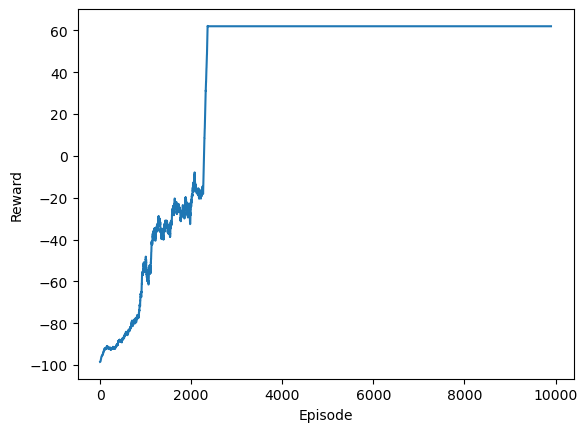

In [14]:
import matplotlib.pyplot as plt

smoothed_rewards = np.convolve(agent.rewards, np.ones(100) / 100, mode='valid')

plt.plot(smoothed_rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [17]:
Q_table = agent.Q_table
non_zero_rows_mask = np.any(Q_table != 0, axis=1)
num_non_zero_rows = np.sum(non_zero_rows_mask)

# Note how only few lines are non-zero.

print(f"Non-zero rows = {num_non_zero_rows}")

Non-zero rows = 460


In [18]:
import pygame

tetris = QLTetris(rows=4, cols=4, max_tiles=50, random_seed=123456)
agent = QLAgent(tetris=tetris, games=1000, alpha=0.2, gamma=1, epsilon=0)
agent.Q_table = np.loadtxt("Q_table.txt")

# GUI parameters.
TILE_SIZE = 20

BLACK = (0, 0, 0)
GREY = (128, 128, 128)
WHITE = (255, 255, 255)
RED =  (255, 0, 0)

# Initialize the game engine.
pygame.init()
pygame.display.set_caption("TETRIS")
screen = pygame.display.set_mode((200 + tetris.cols * TILE_SIZE, 
                                  200 + tetris.rows * TILE_SIZE))
pygame.key.set_repeat(300, 100)  # Set keyboard delay and interval in ms.
font = pygame.font.SysFont("Calibri", 25, True)

# Loop until the window is closed.
running = True
while running:
        
    # Paint game board.
    if pygame.display.get_active():
        screen.fill(WHITE)

        for i in range(tetris.rows):
            for j in range(tetris.cols):
                pygame.draw.rect(screen, 
                    GREY, 
                    [
                        100 + TILE_SIZE * j, 
                        80 + TILE_SIZE * (tetris.rows - i), 
                        TILE_SIZE, 
                        TILE_SIZE,
                    ], 
                    1
                )
                if tetris.board[i][j] > 0:
                    pygame.draw.rect(
                        screen, 
                        BLACK,
                        [
                            101 + TILE_SIZE * j, 
                            81 + TILE_SIZE * (tetris.rows - i), 
                            TILE_SIZE - 2, 
                            TILE_SIZE - 2,
                        ],
                    )
        
        tile = tetris.TILES[tetris.current_tile][tetris.tile_orientation]
        for x in range(len(tile)):
            for y in range(tile[x][0], tile[x][1]):
                pygame.draw.rect(
                    screen,
                    RED,
                    [
                        101 + TILE_SIZE * (x + tetris.tile_x), 
                        81 + TILE_SIZE * (tetris.rows - (y + tetris.tile_y)), 
                        TILE_SIZE - 2,
                        TILE_SIZE - 2,
                    ]
                )
        
        screen.blit(font.render(f"Reward: {tetris.reward}", 
                                True, BLACK), [0, 0])
        screen.blit(font.render(f"Tile {tetris.tile_count}/{tetris.max_tiles}", 
                                True, BLACK), [0, 30])
        if tetris.gameover:
            screen.blit(font.render("G A M E   O V E R", True, RED), 
                        [40, 100 + tetris.rows * TILE_SIZE])
            screen.blit(font.render("Press ESC to try again", True, RED), 
                        [10, 100 + tetris.rows * TILE_SIZE + 30])

    pygame.display.flip()

    # Get user input.
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN:
            agent.next_turn()
            
pygame.quit()

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


game 0/1000 reward nan


In [19]:
# Try also with epsilon = 0.001 and games = 100_000

tetris = QLTetris(rows=4, cols=4, max_tiles=50, random_seed=123456)
agent = QLAgent(tetris=tetris, games=100_000, epsilon=0.001, alpha=0.2, gamma=1)

while agent.next_turn():
    pass

game 0/100000 reward nan
game 100/100000 reward -98.51
game 200/100000 reward -92.5
game 300/100000 reward -91.96
game 400/100000 reward -92.2
game 500/100000 reward -88.35
game 600/100000 reward -87.64
game 700/100000 reward -85.69
game 800/100000 reward -79.75
game 900/100000 reward -78.92
game 1000/100000 reward -68.24
game 1100/100000 reward -51.39
game 1200/100000 reward 36.42
game 1300/100000 reward 46.48
game 1400/100000 reward 28.95
game 1500/100000 reward 62.0
game 1600/100000 reward 57.57
game 1700/100000 reward 58.82
game 1800/100000 reward 3.72
game 1900/100000 reward 52.89
game 2000/100000 reward 59.2
game 2100/100000 reward 53.35
game 2200/100000 reward 48.57
game 2300/100000 reward 62.0
game 2400/100000 reward 59.16
game 2500/100000 reward 56.27
game 2600/100000 reward 62.0
game 2700/100000 reward 62.0
game 2800/100000 reward 60.76
game 2900/100000 reward 57.89
game 3000/100000 reward 55.85
game 3100/100000 reward 57.82
game 3200/100000 reward 62.0
game 3300/100000 rewar

In [ ]:
import matplotlib.pyplot as plt

smoothed_rewards = np.convolve(agent.rewards, np.ones(100) / 100, mode='valid')

plt.plot(smoothed_rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [ ]:
# Interesting to note that the number of non-zero rows increases in this case.

Q_table = agent.Q_table
non_zero_rows_mask = np.any(Q_table != 0, axis=1)
num_non_zero_rows = np.sum(non_zero_rows_mask)


Interesting to note also how once the sequence is fixed it learns very quickly and better than before to do it.

In [ ]:
import pygame

tetris = QLTetris(rows=4, cols=4, max_tiles=50, random_seed=123456)
agent = QLAgent(tetris=tetris, games=1000, epsilon=0, alpha=0.2, gamma=1)
agent.Q_table = np.loadtxt("Q_table.txt")

# GUI parameters.
TILE_SIZE = 20

BLACK = (0, 0, 0)
GREY = (128, 128, 128)
WHITE = (255, 255, 255)
RED =  (255, 0, 0)

# Initialize the game engine.
pygame.init()
pygame.display.set_caption("TETRIS")
screen = pygame.display.set_mode((200 + tetris.cols * TILE_SIZE, 
                                  200 + tetris.rows * TILE_SIZE))
pygame.key.set_repeat(300, 100)  # Set keyboard delay and interval in ms.
font = pygame.font.SysFont("Calibri", 25, True)

# Loop until the window is closed.
running = True
while running:
        
    # Paint game board.
    if pygame.display.get_active():
        screen.fill(WHITE)

        for i in range(tetris.rows):
            for j in range(tetris.cols):
                pygame.draw.rect(screen, 
                    GREY, 
                    [
                        100 + TILE_SIZE * j, 
                        80 + TILE_SIZE * (tetris.rows - i), 
                        TILE_SIZE, 
                        TILE_SIZE,
                    ], 
                    1
                )
                if tetris.board[i][j] > 0:
                    pygame.draw.rect(
                        screen, 
                        BLACK,
                        [
                            101 + TILE_SIZE * j, 
                            81 + TILE_SIZE * (tetris.rows - i), 
                            TILE_SIZE - 2, 
                            TILE_SIZE - 2,
                        ],
                    )
        
        tile = tetris.TILES[tetris.current_tile][tetris.tile_orientation]
        for x in range(len(tile)):
            for y in range(tile[x][0], tile[x][1]):
                pygame.draw.rect(
                    screen,
                    RED,
                    [
                        101 + TILE_SIZE * (x + tetris.tile_x), 
                        81 + TILE_SIZE * (tetris.rows - (y + tetris.tile_y)), 
                        TILE_SIZE - 2,
                        TILE_SIZE - 2,
                    ]
                )
        
        screen.blit(font.render(f"Reward: {tetris.reward}", 
                                True, BLACK), [0, 0])
        screen.blit(font.render(f"Tile {tetris.tile_count}/{tetris.max_tiles}", 
                                True, BLACK), [0, 30])
        if tetris.gameover:
            screen.blit(font.render("G A M E   O V E R", True, RED), 
                        [40, 100 + tetris.rows * TILE_SIZE])
            screen.blit(font.render("Press ESC to try again", True, RED), 
                        [10, 100 + tetris.rows * TILE_SIZE + 30])

    pygame.display.flip()

    # Get user input.
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN:
            agent.next_turn()
            
pygame.quit()

## Q-Learning with a Random Tile Sequence

In [ ]:
tetris = QLTetris(rows=4, cols=4, max_tiles=50, random_seed=None)
agent = QLAgent(tetris=tetris, games=1_000_000, epsilon=0.001, alpha=0.2, gamma=1)

while agent.next_turn():
    pass

In [ ]:
import matplotlib.pyplot as plt

smoothed_rewards = np.convolve(agent.rewards, np.ones(100) / 100, mode='valid')

plt.plot(smoothed_rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')

In [ ]:
import pygame

tetris = QLTetris(rows=4, cols=4, max_tiles=50, random_seed=False)
agent = QLAgent(tetris=tetris, games=1000, alpha=0.2, gamma=1, epsilon=0)
agent.Q_table = np.loadtxt("Q_table.txt")

# GUI parameters.
TILE_SIZE = 20

BLACK = (0, 0, 0)
GREY = (128, 128, 128)
WHITE = (255, 255, 255)
RED =  (255, 0, 0)

# Initialize the game engine.
pygame.init()
pygame.display.set_caption("TETRIS")
screen = pygame.display.set_mode((200 + tetris.cols * TILE_SIZE, 
                                  200 + tetris.rows * TILE_SIZE))
pygame.key.set_repeat(300, 100)  # Set keyboard delay and interval in ms.
font = pygame.font.SysFont("Calibri", 25, True)

# Loop until the window is closed.
running = True
while running:
        
    # Paint game board.
    if pygame.display.get_active():
        screen.fill(WHITE)

        for i in range(tetris.rows):
            for j in range(tetris.cols):
                pygame.draw.rect(screen, 
                    GREY, 
                    [
                        100 + TILE_SIZE * j, 
                        80 + TILE_SIZE * (tetris.rows - i), 
                        TILE_SIZE, 
                        TILE_SIZE,
                    ], 
                    1
                )
                if tetris.board[i][j] > 0:
                    pygame.draw.rect(
                        screen, 
                        BLACK,
                        [
                            101 + TILE_SIZE * j, 
                            81 + TILE_SIZE * (tetris.rows - i), 
                            TILE_SIZE - 2, 
                            TILE_SIZE - 2,
                        ],
                    )
        
        tile = tetris.TILES[tetris.current_tile][tetris.tile_orientation]
        for x in range(len(tile)):
            for y in range(tile[x][0], tile[x][1]):
                pygame.draw.rect(
                    screen,
                    RED,
                    [
                        101 + TILE_SIZE * (x + tetris.tile_x), 
                        81 + TILE_SIZE * (tetris.rows - (y + tetris.tile_y)), 
                        TILE_SIZE - 2,
                        TILE_SIZE - 2,
                    ]
                )
        
        screen.blit(font.render(f"Reward: {tetris.reward}", 
                                True, BLACK), [0, 0])
        screen.blit(font.render(f"Tile {tetris.tile_count}/{tetris.max_tiles}", 
                                True, BLACK), [0, 30])
        if tetris.gameover:
            screen.blit(font.render("G A M E   O V E R", True, RED), 
                        [40, 100 + tetris.rows * TILE_SIZE])
            screen.blit(font.render("Press ESC to try again", True, RED), 
                        [10, 100 + tetris.rows * TILE_SIZE + 30])

    pygame.display.flip()

    # Get user input.
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN:
            agent.next_turn()
            
pygame.quit()

## Deep Q-Learning

In Deep Q-Learning, Q-Network (QNet) and Target Network (TargetNet) are two key components, and they serve different purposes in the learning process:

1. **Q-Network (QNet):** 
    - **Primary Role:** QNet is the main neural network that is being trained to approximate the Q-value function. The Q-value function estimates the total expected reward that an agent can obtain, starting from a given state and performing a specific action. This network is actively updated at every step (or after a certain number of steps) during the training process.
    - **Learning:** QNet learns by continuously updating its weights based on the Temporal Difference (TD) error, which is the difference between the predicted Q-value and the target Q-value. The update is typically done using backpropagation and an optimization algorithm like Adam or RMSprop.

2. **Target Network (TargetNet):**
    - **Primary Role:** TargetNet is a separate neural network that has the same architecture as QNet but with a different set of weights. Its main role is to provide a stable target for the QNet to learn from. The weights of TargetNet are periodically updated with the weights of QNet.
    - **Stability:** The key reason for using a separate target network is to stabilize the learning process. In Q-learning, the target Q-value (used in calculating the TD error) depends on the Q-value itself. This can lead to instability and divergence if the same network is used for both selecting actions and evaluating the value of those actions. By using a separate TargetNet for generating the target Q-values, the learning process becomes more stable.

In summary, QNet is the network that is actively learning and being updated continually, while TargetNet is used to generate stable target values for the QNet to learn from. The use of a TargetNet helps in stabilizing the training process by providing consistent targets for a period of time before being updated.

In [ ]:
import deeplay as dl
import torch

class DQLAgent(dl.Application):
    
    def __init__(self, alpha, gamma, epsilon_max, epsilon_min, epsilon_scale, games, 
                 hidden_units, 
                 replay_buffer_size, batch_size, sync_target_game_count,
                 tetris, 
                 **kwargs):
        self.alpha = alpha  # Alpha is the learning rate.
        self.gamma = gamma  # Discount factor.
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min  # Probability to choose a random action in the epsilon-greedy policy.
        self.epsilon_scale = epsilon_scale  # Decay scale of the game number where epsilon changes from unity to epsilon.
        self.epsilon = self.epsilon_max
        self.games = games
        self.game = 0
        self.tetris = tetris
        
        self.rewards = np.zeros(games)
        self.max_reward = 0
        self.buffer = []

        self.replay_buffer_size = replay_buffer_size  # Size of the experience replay buffer.
        self.batch_size = batch_size  # Number of samples taken from the experience replay buffer for each update.
        self.sync_target_game_count = sync_target_game_count  # Number of episodes between synchronizations of the target network.

        self.state_size = (
            self.tetris.cols * self.tetris.rows  # Cells in board.
            + 1 + np.floor(np.log2(len(Tetris.TILES) - 1)).astype(int)  # Tiles
        )
        self.state_num = 2 ** self.state_size
        
        self.position_num = self.tetris.rows
        self.orientation_num = np.max([len(tile) for tile in Tetris.TILES])
        self.action_num = self.position_num * self.orientation_num

        self.q_net = self.get_net(hidden_units)
        self.target_net = self.get_net(hidden_units)

        super().__init__(
            loss=torch.nn.MSELoss(),
            optimizer=torch.optim.Adam(self.q_net.parameters(), lr=0.001),  ### Is it strictly needed to have self.q_net.parameters() as argument?
            **kwargs, 
        )

        self.update_state()
        
    def get_net(self, hidden_units):
        net = dl.MultiLayerPerceptron(
            in_features=self.state_size,
            hidden_features=hidden_units,
            out_features=self.action_num,
        )
        net.blocks[:-1].activation = torch.nn.ReLU()  # GELU stabilizes training, ReLU works ok as well.
        return net.build()
    
    def update_state(self):
        # Convert tile to binary list.
        tile = bin(self.tetris.current_tile)[2:].zfill(2) ### instead of 2 use proper variable for the digits for tiles
        tile = np.array([int(i) for i in tile])
    
        # Convert board to binary list.
        board = np.copy(self.tetris.board.reshape((-1,))).astype(int)
        board[board == Tetris.UNDEFINED] = 0
        
        self.state_binary = np.append(tile, board)
        self.state = torch.tensor(self.state_binary, dtype=torch.float32)

    def next_turn(self):
        if self.tetris.gameover:
            self.rewards[self.game] = self.tetris.reward
            if self.game % 100 == 0:
                av_reward = np.mean(self.rewards[self.game - 100:self.game])
                print(f"game {self.game}/{self.games} reward {av_reward}")
                if av_reward > self.max_reward:
                    self.max_reward = av_reward
                    torch.save(self.q_net.state_dict(), 'q_net.pth')
            
            self.game += 1
            self.epsilon = max(self.epsilon_min, 
                               self.epsilon_max - self.game / self.epsilon_scale)
            if self.game < self.games:
                if ((len(self.buffer) >= self.replay_buffer_size)
                    and (self.game % self.sync_target_game_count == 0)):
                    self.target_net.load_state_dict(self.q_net.state_dict())

                self.tetris.restart()
            else:
                return False  # Finish.
        else:
            old_state = self.state
            
            # Select action.
            with torch.no_grad():
                if np.random.rand() < self.epsilon:
                    action = np.random.randint(self.action_num)
                else:
                    state = self.state.view(1, self.state_size)
                    output = self.q_net(state).detach().numpy()[0]
                    action = np.argmax(output)
            
                # Extract rotation and movement from action parameter.
                new_x = action // self.position_num
                new_orientation = action % self.orientation_num
                
                # Execute action and drop tile.
                self.tetris.teleport(new_x, new_orientation)
                reward = self.tetris.drop()
                    
                # Update the state.
                self.update_state()
                new_state = self.state
                
                # Append to buffer and train network.
                self.buffer.append({
                    "old_state":old_state,
                    "action":action,
                    "reward":reward,
                    "new_state":new_state,
                    "gameover":self.tetris.gameover,
                })
                if len(self.buffer) >= self.replay_buffer_size + 1:
                    self.buffer.pop(0)
            if len(self.buffer) >= self.replay_buffer_size:
                # Training step.
                batch = random.sample(self.buffer, self.batch_size)

                # Store states in a list
                states = []
                next_states = []
                for sample in batch:
                    states.append(sample["old_state"])
                    next_states.append(sample["new_state"])
                # Initialize targets and target mask
                targets = torch.zeros(self.batch_size, self.action_num)
                targets_mask = torch.zeros(self.batch_size, self.action_num)
                # Evaluate next state with target network
                with torch.no_grad():
                    q_hat = self.target_net(torch.stack(next_states, dim=0))
                # Computes targets
                for idx, sample in enumerate(batch):
                    if sample["gameover"]:
                        y = sample["reward"]
                    else:
                        y = sample["reward"] + np.nanmax(q_hat[idx, :])
                    targets[idx, sample["action"]] = y
                    targets_mask[idx, sample["action"]] = 1
                # Evaluate old states, apply mask and update weights
                self.optimizer.zero_grad()
                outputs = self.q_net(torch.stack(states, dim=0)) * targets_mask
                loss = self.loss(outputs, targets)
                loss.backward()
                self.optimizer.step()
        
        return True  # Continue.    


In [ ]:
tetris = QLTetris(rows=4, cols=4, max_tiles=50, random_seed=False)
agent = DQLAgent(tetris=tetris, games=10_000, 
                 alpha=0.001, gamma=1, epsilon_max=1, epsilon_min=0.001, epsilon_scale=5000, 
                 hidden_units=[128, 128],
                 replay_buffer_size=10000, batch_size=64, 
                 sync_target_game_count=100)

print(agent.q_net)
print(agent.target_net)

In [ ]:
while agent.next_turn():
    pass

In [ ]:
import matplotlib.pyplot as plt

smoothed_rewards = np.convolve(agent.rewards, np.ones(100) / 100, mode='valid')

plt.plot(smoothed_rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')

In [ ]:
import pygame

tetris = QLTetris(rows=4, cols=4, max_tiles=50, random_seed=False)
agent = DQLAgent(tetris=tetris, games=10_000, 
                 alpha=0.001, gamma=1, epsilon_max=0, epsilon_min=0, epsilon_scale=5000, 
                 hidden_units=[128, 128],
                 replay_buffer_size=10000, batch_size=64, 
                 sync_target_game_count=100)

model_state_dict = torch.load("q_net.pth")
agent.q_net.load_state_dict(model_state_dict)
agent.target_net.load_state_dict(model_state_dict)

# GUI parameters.
TILE_SIZE = 20

BLACK = (0, 0, 0)
GREY = (128, 128, 128)
WHITE = (255, 255, 255)
RED =  (255, 0, 0)

# Initialize the game engine.
pygame.init()
pygame.display.set_caption("TETRIS")
screen = pygame.display.set_mode((200 + tetris.cols * TILE_SIZE, 
                                  200 + tetris.rows * TILE_SIZE))
pygame.key.set_repeat(300, 100)  # Set keyboard delay and interval in ms.
font = pygame.font.SysFont("Calibri", 25, True)

# Loop until the window is closed.
running = True
while running:
        
    # Paint game board.
    if pygame.display.get_active():
        screen.fill(WHITE)

        for i in range(tetris.rows):
            for j in range(tetris.cols):
                pygame.draw.rect(screen, 
                    GREY, 
                    [
                        100 + TILE_SIZE * j, 
                        80 + TILE_SIZE * (tetris.rows - i), 
                        TILE_SIZE, 
                        TILE_SIZE,
                    ], 
                    1
                )
                if tetris.board[i][j] > 0:
                    pygame.draw.rect(
                        screen, 
                        BLACK,
                        [
                            101 + TILE_SIZE * j, 
                            81 + TILE_SIZE * (tetris.rows - i), 
                            TILE_SIZE - 2, 
                            TILE_SIZE - 2,
                        ],
                    )
        
        tile = tetris.TILES[tetris.current_tile][tetris.tile_orientation]
        for x in range(len(tile)):
            for y in range(tile[x][0], tile[x][1]):
                pygame.draw.rect(
                    screen,
                    RED,
                    [
                        101 + TILE_SIZE * (x + tetris.tile_x), 
                        81 + TILE_SIZE * (tetris.rows - (y + tetris.tile_y)), 
                        TILE_SIZE - 2,
                        TILE_SIZE - 2,
                    ]
                )
        
        screen.blit(font.render(f"Reward: {tetris.reward}", 
                                True, BLACK), [0, 0])
        screen.blit(font.render(f"Tile {tetris.tile_count}/{tetris.max_tiles}", 
                                True, BLACK), [0, 30])
        if tetris.gameover:
            screen.blit(font.render("G A M E   O V E R", True, RED), 
                        [40, 100 + tetris.rows * TILE_SIZE])
            screen.blit(font.render("Press ESC to try again", True, RED), 
                        [10, 100 + tetris.rows * TILE_SIZE + 30])

    pygame.display.flip()

    # Get user input.
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN:
            agent.next_turn()
            
pygame.quit()